In [131]:
import os
import math

import netCDF4
import numpy as np
import pandas
from osgeo import gdal

import pyart

from matplotlib import pyplot as plt

In [154]:
sites_ffn   = '/home/548/jss548/dev/SevereWeather/BonnProject/3DwindLobes/dwd_siteinfo_current.txt'
geotiff_ffn = '/home/548/jss548/dev/SevereWeather/BonnProject/3DwindLobes/overlap.tif'

radar_dist_threshold = 300000 #m
overlap_dist_threshold = 150000 #m
min_angle = math.radians(30) #deg
max_angle = math.radians(150) #deg
max_overlap_count = 3

lat_0   = 51.023   #grid centre lat
lon_0   = 10.098   #grid centre lon
grid_range = 500000.  #m
grid_space = 1000.    #m
R       = 6370997. #m, earth radius

In [155]:
def read_csv(csv_ffn, header_line):
    """
    CSV reader used for the radar locations file (comma delimited)
    
    Parameters:
    ===========
        csv_ffn: str
            Full filename to csv file
            
        header_line: int or None
            to use first line of csv as header = 0, use None to use column index
            
    Returns:
    ========
        as_dict: dict
            csv columns are dictionary
    
    """
    df = pandas.read_csv(csv_ffn, header=header_line, skipinitialspace=True)
    as_dict = df.to_dict(orient='list')
    return as_dict

def get_distance(lat_1, lng_1, lat_2, lng_2, R): 
    
    s_lat = lat_1*np.pi/180.0                      
    s_lng = np.deg2rad(lng_1)     
    e_lat = np.deg2rad(lat_2)                       
    e_lng = np.deg2rad(lng_2)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d)) 

def get_bca(rad1_lon, rad1_lat, rad2_lon, rad2_lat, x, y, projparams):
    """
    This function gets the beam crossing angle between two lat/lon pairs.
    Parameters
    ==========
    rad1_lon: float
        The longitude of the first radar.
    rad1_lat: float
        The latitude of the first radar.
    rad2_lon: float
        The longitude of the second radar.
    rad2_lat: float
        The latitude of the second radar.
    x: nD float array
        The Cartesian x coordinates of the grid
    y: nD float array
        The Cartesian y corrdinates of the grid
    projparams: Py-ART projparams
        The projection parameters of the Grid
    Returns
    =======
    bca: nD float array
        The beam crossing angle between the two radars in radians.
    """

    rad1 = pyart.core.geographic_to_cartesian(rad1_lon, rad1_lat, projparams)
    rad2 = pyart.core.geographic_to_cartesian(rad2_lon, rad2_lat, projparams)
    # Create grid with Radar 1 in center

    x = x-rad1[0]
    y = y-rad1[1]
    rad2 = np.array(rad2) - np.array(rad1)
    a = np.sqrt(np.multiply(x, x) + np.multiply(y, y))
    b = np.sqrt(pow(x-rad2[0], 2) + pow(y-rad2[1], 2))
    c = np.sqrt(rad2[0]*rad2[0] + rad2[1]*rad2[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-rad2[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

def write_grid_geotiff(input_array, filename, geo_info,
                       cmap='viridis', vmin=0, vmax=75):
    """
    Write a 2D array to a GeoTIFF file.
    
    Parameters
    ----------
    input_array : numpy array
        Grid to write to file.
    filename : str
        Filename for the GeoTIFF.
    geo_info : dict
        contains grid_step, grid_dist, radar_lat, radar_lon
        
    Other Parameters
    ----------------
    cmap : str or matplotlib.colors.Colormap object, optional
        Colormap to use for RGB output or SLD file.
    vmin : int or float, optional
        Minimum value to color for RGB output or SLD file.
    vmax : int or float, optional
        Maximum value to color for RGB output or SLD file.
    """
    
    # Determine whether filename template already contains a suffix
    # If not, append an appropriate one.
    if '.' not in filename:
        name = filename
        end = 'tif'
        ofile = name + "." + end
    else:
        ofile = filename
        
    
    dist      = geo_info['grid_dist']
    rangestep = geo_info['grid_step']
    lat       = geo_info['radar_lat'] #lat origin
    lon       = geo_info['radar_lon'] #lon origin (middle of grid)
    
    # Check if masked array; if so, fill missing data
    data = input_array.astype(float)

    iproj = 'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",' + \
        'SPHEROID["WGS84",6378137,298.257223563]],' + \
        'PRIMEM["Greenwich",0],' + \
        'UNIT["degree",0.0174532925199433]],' + \
        'PROJECTION["Azimuthal_Equidistant"],' + \
        'PARAMETER["latitude_of_center",' + str(lat) + '],' + \
        'PARAMETER["longitude_of_center",' + str(lon) + '],' + \
        'PARAMETER["false_easting",0],' + \
        'PARAMETER["false_northing",0],' + \
        'UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'
    out_driver = gdal.GetDriverByName("GTiff")

    # Single-channel, floating-point output
    dst_options = ['COMPRESS=LZW', 'ALPHA=YES']
    dst_ds = out_driver.Create(
        ofile, data.shape[1], data.shape[0], 1,
        gdal.GDT_Float32, dst_options)

    # Common Projection and GeoTransform
    dst_ds.SetGeoTransform([-dist, rangestep, 0, dist, 0, -rangestep])
    dst_ds.SetProjection(iproj)

    # Final output
    dst_ds.GetRasterBand(1).WriteArray(data[::-1, :])
    dst_ds.FlushCache()
    dst_ds = None


In [156]:
#create lat lon grid
projparams = {'proj':'pyart_aeqd','R':R,'lat_0':lat_0, 'lon_0':lon_0}

x_vec = np.arange(-grid_range, grid_range+grid_space, grid_space)
y_vec = np.arange(-grid_range, grid_range+grid_space, grid_space)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)
lon_grid, lat_grid = pyart.core.cartesian_to_geographic_aeqd(x_grid, y_grid, lon_0, lat_0, R)

In [157]:
#read site info
site_dict = read_csv(sites_ffn, 0)
site_lat = site_dict['lat']
site_lon = site_dict['lon']
site_id  = site_dict['id']
lobe_list = []

#calculate lobe pairs
for i,_ in enumerate(site_id):
    for j,_ in enumerate(site_id):
        #skip same radar
        if i==j:
            continue
        #skip processed radars
        if [i,j] in lobe_list or [j,i] in lobe_list:
            continue
        #calc distance
        radar_dist = get_distance(site_lat[i], site_lon[i], site_lat[j], site_lon[j], R)
        if radar_dist <= radar_dist_threshold:
            lobe_list.append([i,j])
print(lobe_list)

[[0, 1], [0, 4], [0, 6], [0, 7], [0, 18], [1, 7], [1, 13], [1, 14], [1, 16], [2, 3], [2, 10], [2, 13], [2, 16], [3, 8], [3, 9], [3, 10], [3, 12], [3, 15], [4, 6], [4, 7], [4, 11], [4, 12], [4, 17], [4, 18], [5, 9], [5, 11], [5, 12], [5, 15], [6, 7], [6, 10], [6, 11], [6, 12], [6, 16], [6, 17], [6, 18], [7, 10], [7, 12], [7, 13], [7, 14], [7, 16], [7, 17], [7, 18], [8, 9], [8, 10], [8, 15], [9, 10], [9, 12], [9, 15], [10, 12], [10, 15], [10, 16], [10, 17], [11, 12], [11, 15], [11, 17], [11, 18], [12, 15], [12, 16], [12, 17], [12, 18], [13, 14], [13, 16], [14, 16], [17, 18]]


In [171]:
overlap_grid = np.zeros_like(x_grid)

for lobe_pair in lobe_list:
    #extract pair coordinates
    rad1_lat = site_lat[lobe_pair[0]]
    rad1_lon = site_lon[lobe_pair[0]]
    rad2_lat = site_lat[lobe_pair[1]]
    rad2_lon = site_lon[lobe_pair[1]]
    
    #calculate ray angle
    ray_angle   = get_bca(rad1_lon, rad1_lat, rad2_lon, rad2_lat, x_grid, y_grid, projparams)
    #calculate distance from radars
    radar1_dist = get_distance(rad1_lat, rad1_lon, lat_grid, lon_grid, R)
    radar2_dist = get_distance(rad2_lat, rad2_lon, lat_grid, lon_grid, R)
    #threshold dist, angle and combine
    dist_mask = np.logical_and(radar1_dist<=overlap_dist_threshold, radar2_dist<=overlap_dist_threshold)
    ang_mask  = np.logical_and(ray_angle>=min_angle, ray_angle<+max_angle)
    combine_mask = np.logical_and(dist_mask, ang_mask)
    #add  to overlap
    overlap_grid = overlap_grid + combine_mask

/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid

/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


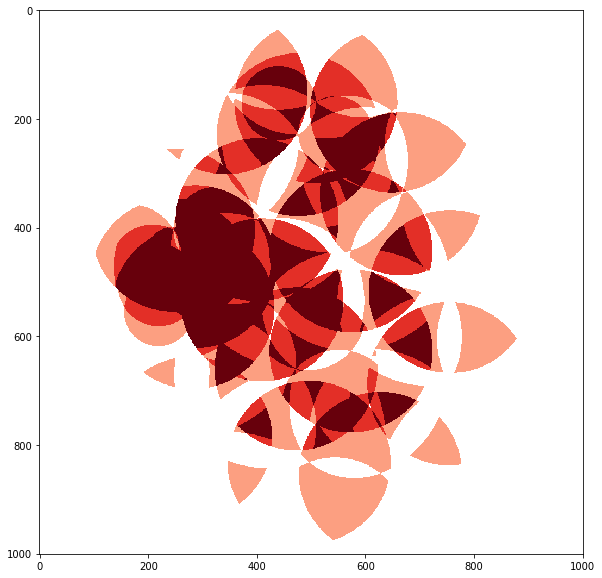

In [173]:
#apply max overlap
overlap_grid[overlap_grid>max_overlap_count] = max_overlap_count

#add transparent layer
overlap_grid[overlap_grid==0] = np.nan
fig = plt.figure(facecolor='white', figsize=(10, 10))
plt.imshow(overlap_grid, 'Reds', vmin=0, vmax=3)

In [159]:
#write to geotiff

geo_info = {'grid_dist':grid_range, 'grid_step':grid_space,'radar_lat':lat_0,'radar_lon':lon_0}
write_grid_geotiff(overlap_grid, geotiff_ffn, geo_info, cmap='oranges', vmin=0, vmax=max_overlap_count)

In [ ]:
#create leaflet file import folium

#use mapbox layer as background
#add drawing tools
#add overlap image
#add radar markers
#upload to S3

#need to do this locally!!!

#don't need a geotiff for leaflet too...